In [1]:
import scanpy as sc
import mudata as md
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import sys
sys.path.append('../')

from latentcor import get_tps, latentcor
from utils.gglasso_pipeline import gg_lasso_network_analysis

np.random.seed(42)

In [2]:
ec_adata = sc.read_h5ad(filename='../data/preprocessed/ec_prepro.h5ad')
ec_adata

AnnData object with n_obs × n_vars = 5964 × 3379
    obs: 'strains', 'n_genes_by_counts', 'total_counts', 'n_genes', 'n_counts'
    var: 'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'var_counts', 'n_cells'
    uns: 'genes_match', 'protein_match', 'unmatch_genes'
    layers: 'counts', 'norm_counts', 'sqrt_counts', 'sqrt_norm_counts'

In [3]:
sc.pp.calculate_qc_metrics(ec_adata, inplace=True)

In [4]:
ec_adata.var

,strains,matchin_protein,protein,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,var_counts,n_cells,log1p_mean_counts,log1p_total_counts
cds-ECs_0019,GSM5456503_Ec_CDS,no_match,no_match,2,0.000335,99.966465,2.0,0.000007,2,0.000335,1.098612
cds-ECs_0219,GSM5456503_Ec_CDS,no_match,no_match,1,0.000168,99.983233,1.0,0.000003,1,0.000168,0.693147
cds-ECs_0271,GSM5456503_Ec_CDS,no_match,no_match,3,0.000503,99.949698,3.0,0.000010,3,0.000503,1.386294
cds-ECs_0277,GSM5456503_Ec_CDS,no_match,no_match,1,0.000168,99.983233,1.0,0.000003,1,0.000168,0.693147
cds-ECs_0293,GSM5456503_Ec_CDS,no_match,no_match,8,0.001341,99.865862,8.0,0.000027,8,0.001340,2.197225
...,...,...,...,...,...,...,...,...,...,...,...
cds-YP_009502668.1,GSM5456486_MGH66_Abx3_P1_align2,match,YP_009502668.1,1,0.000168,99.983233,1.0,0.000003,1,0.000168,0.693147
cds-YP_009502669.1,GSM5456486_MGH66_Abx3_P1_align2,match,YP_009502669.1,2,0.000335,99.966465,2.0,0.000007,2,0.000335,1.098612
cds-YP_009502672.1,GSM5456486_MGH66_Abx3_P1_align2,match,YP_009502672.1,2,0.000335,99.966465,2.0,0.000007,2,0.000335,1.098612
cds-YP_009502673.1,GSM5456486_MGH66_Abx3_P1_align2,match,YP_009502673.1,1,0.000335,99.983233,2.0,0.000014,1,0.000335,1.098612


Looking at gene cds-ECs_0293 (5th entry) to see whether its 1 copy in 8 cells or maybe sth like 2x3 + 1x2
--> 8x1 (can also be seen by total_counts/n_cells)

In [48]:
ec_adata[:,4].var

,strains,matchin_protein,protein,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,var_counts,n_cells,log1p_mean_counts,log1p_total_counts
cds-ECs_0293,GSM5456503_Ec_CDS,no_match,no_match,8,0.001341,99.865862,8.0,0.000027,8,0.00134,2.197225


In [47]:
np.unique(ec_adata[:,4].X.A, return_counts=True)

(array([0., 1.], dtype=float32), array([5956,    8], dtype=int64))

Histogram of gene counts without zeros. Most genes have very low abundance/copy number (~<25 counts per gene)

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='total_counts', ylabel='Count'>

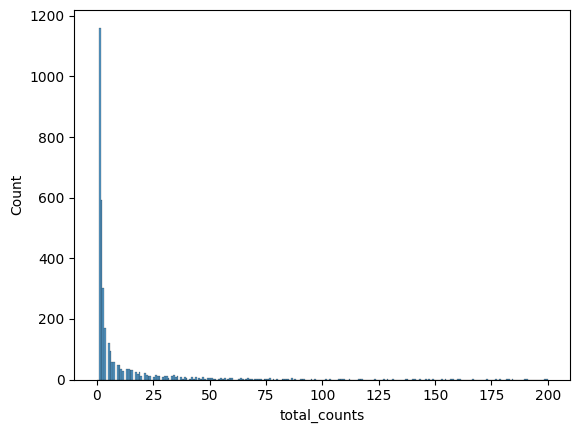

In [37]:
sns.histplot(ec_adata.var.total_counts, binrange=(0, 200),)

Therefore most of the cells also have low gene expression over all (~<25 counts per cell)

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='total_counts', ylabel='Count'>

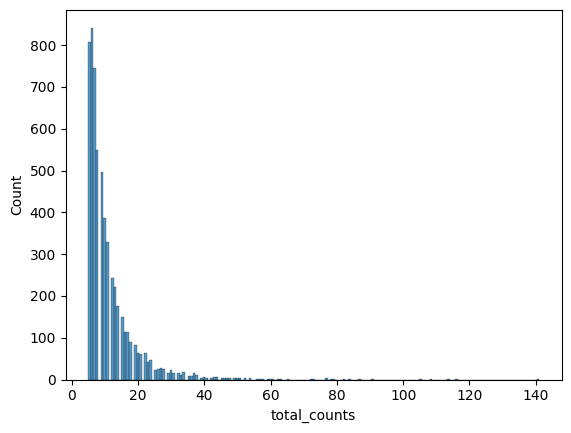

In [46]:
sns.histplot(ec_adata.obs.total_counts)

Looking at the highest expressed gene in ecoli: expressed in lots of cells(1687), not super high expressed in low amount of cells; not labeled as e coli gene?

In [50]:
ec_adata[:,np.where(ec_adata.var.total_counts == ec_adata.var.total_counts.max())[0][0]].var

,strains,matchin_protein,protein,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,var_counts,n_cells,log1p_mean_counts,log1p_total_counts
cds-NP_312192.1,GSM5456505_PsA_CDS,match,NP_312192.1,1687,0.389336,71.713615,2322.0,0.014258,1687,0.328826,7.750615


In [23]:
np.unique(ec_adata[:,2555].X.A, return_counts=True)

(array([0., 1., 2., 3., 4., 5., 6., 7., 8.], dtype=float32),
 array([4277, 1249,  313,   81,   28,   10,    2,    2,    2], dtype=int64))

Relationship between n_cells and total_counts very linear meaning that lots of the cells express lots of the genes in very low amounts

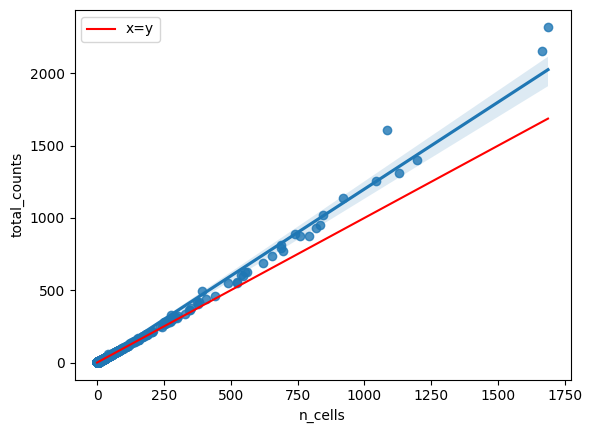

In [64]:
lim = min(ec_adata.var.n_cells.max(), ec_adata.var.total_counts.max())
line = [0, lim]

sns.regplot(ec_adata.var, x='n_cells', y='total_counts')
plt.plot(line, line, color='red', label='x=y')
plt.legend()
plt.show()

Evaluating how sparse the genex matrix is

In [15]:
ec_adata_bool_X = np.array(ec_adata.X.A,dtype=bool)

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


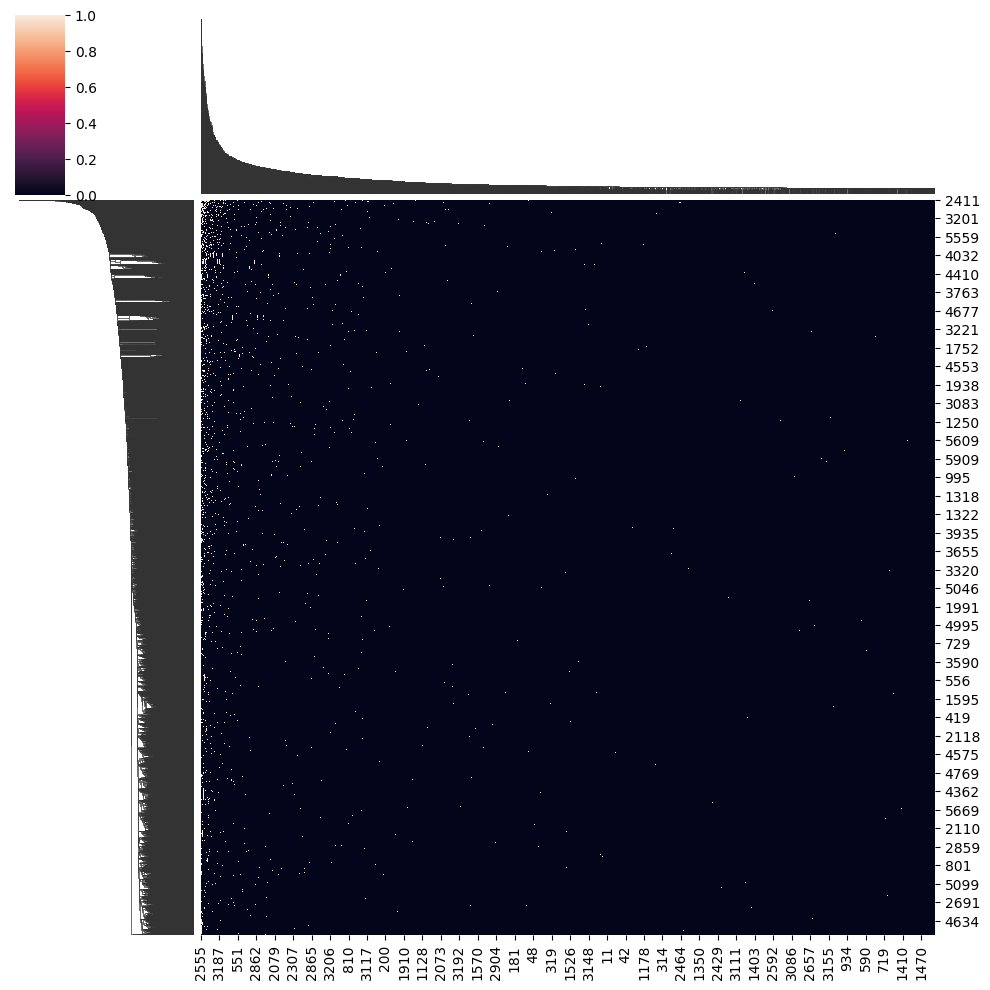

In [70]:
sns.clustermap(ec_adata_bool_X)

In [16]:
print('Sparsity P: ', ec_adata_bool_X.sum() / (ec_adata_bool_X.shape[0] * ec_adata_bool_X.shape[1]))

Sparsity P:  0.003040091193307621


## 50 hvg

In [4]:
sc.pp.highly_variable_genes(ec_adata, n_top_genes=50)
ec_adata_hvg50 = ec_adata[:, ec_adata.var['highly_variable']].copy()
ec_adata_hvg50

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


AnnData object with n_obs × n_vars = 5964 × 50
    obs: 'strains', 'n_genes_by_counts', 'total_counts', 'n_genes', 'n_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'var_counts', 'n_cells', 'log1p_mean_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'genes_match', 'protein_match', 'unmatch_genes', 'hvg'
    layers: 'counts', 'norm_counts', 'sqrt_counts', 'sqrt_norm_counts'

In [5]:
sc.pp.calculate_qc_metrics(ec_adata_hvg50, inplace=True, percent_top=(5, 10, 25))

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='total_counts', ylabel='Count'>

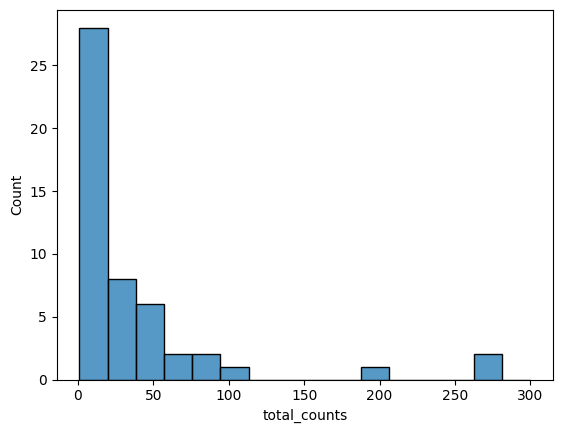

In [6]:
sns.histplot(ec_adata_hvg50.var.total_counts, binrange=(1, 300))

Scatter shows that the information in the gen expression matrix contains lots of ones.

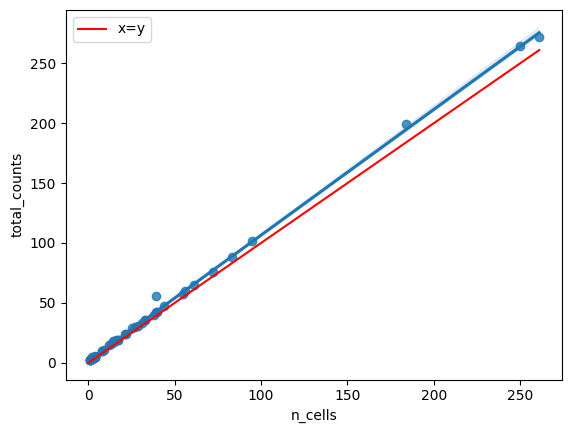

In [7]:
lim = min(ec_adata_hvg50.var.n_cells.max(), ec_adata.var.total_counts.max())
line = [0, lim]

sns.regplot(ec_adata_hvg50.var, x='n_cells', y='total_counts')
plt.plot(line, line, color='red', label='x=y')
plt.legend()
plt.show()

In [10]:
ec_adata_hvg50_bool_X = np.array(ec_adata_hvg50.X.A,dtype=bool)
ec_adata_hvg50_bool_X

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

<Axes: >

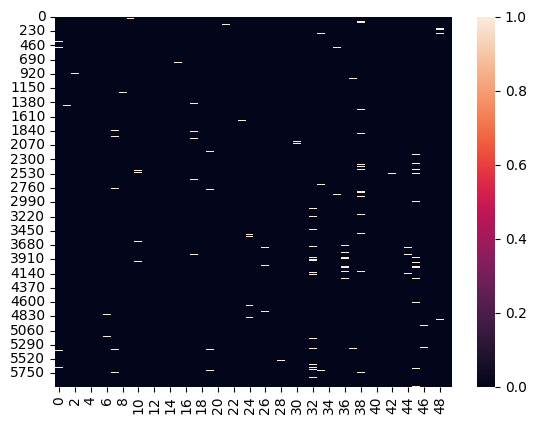

In [17]:
sns.heatmap(ec_adata_hvg50_bool_X)

In [13]:
print('Sparsity P: ', ec_adata_hvg50_bool_X.sum() / (ec_adata_hvg50_bool_X.shape[0] * ec_adata_hvg50_bool_X.shape[1]))

Sparsity P:  0.005744466800804829


<Axes: >

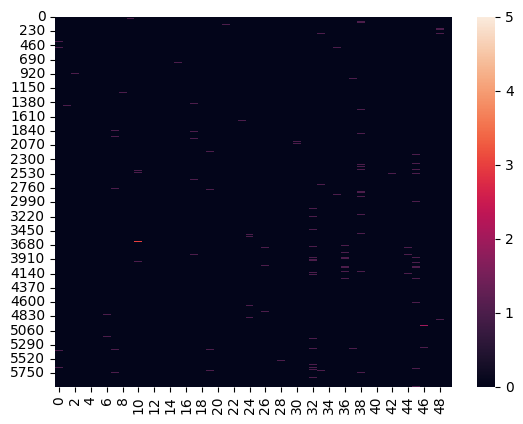

In [18]:
sns.heatmap(ec_adata_hvg50.X.A)

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


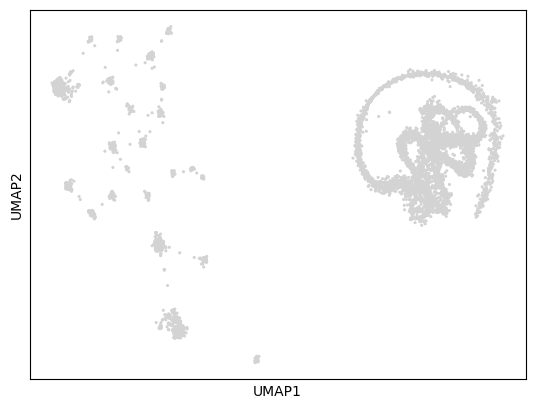

In [20]:
sc.pp.neighbors(ec_adata_hvg50, use_rep='X')
sc.tl.umap(ec_adata_hvg50)
sc.pl.umap(ec_adata_hvg50)

Due to only selecting top50 HVGs lots of cells only contain zeros

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

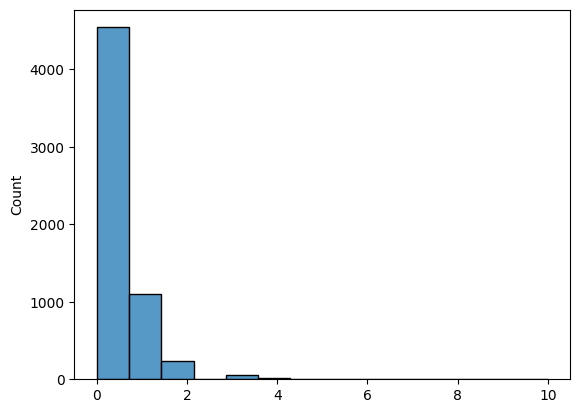

In [21]:
sns.histplot(ec_adata_hvg50.X.A.sum(axis=1))

In [22]:
np.unique(ec_adata_hvg50.X.A.sum(axis=1), return_counts=True)

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6., 10.], dtype=float32),
 array([4542, 1098,  239,   58,   17,    7,    2,    1], dtype=int64))

1) remove genes that are only expressed in one cell
2) Remove cells that do not express any of the remaining genes

In [23]:
print(ec_adata_hvg50.shape)
sc.pp.filter_genes(ec_adata_hvg50, min_cells=2)
print(ec_adata_hvg50.shape)

(5964, 50)
(5964, 45)


In [24]:
print(ec_adata_hvg50.shape)
sc.pp.filter_cells(ec_adata_hvg50, min_genes=1)
print(ec_adata_hvg50.shape)

(5964, 45)
(1419, 45)


In [25]:
np.unique(ec_adata_hvg50.X.A.sum(axis=1), return_counts=True)

(array([ 1.,  2.,  3.,  4.,  5.,  6., 10.], dtype=float32),
 array([1099,  236,   58,   17,    6,    2,    1], dtype=int64))

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


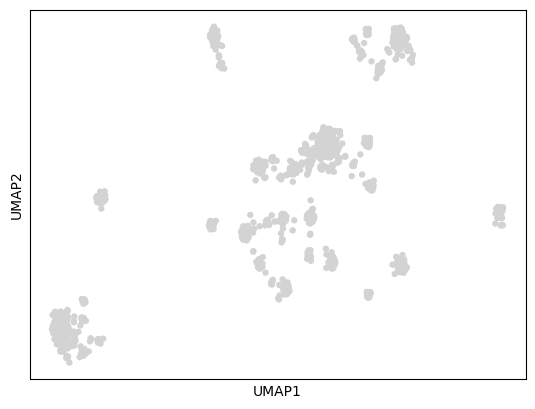

In [26]:
sc.pp.neighbors(ec_adata_hvg50, use_rep='X')
sc.tl.umap(ec_adata_hvg50)
sc.pl.umap(ec_adata_hvg50)

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


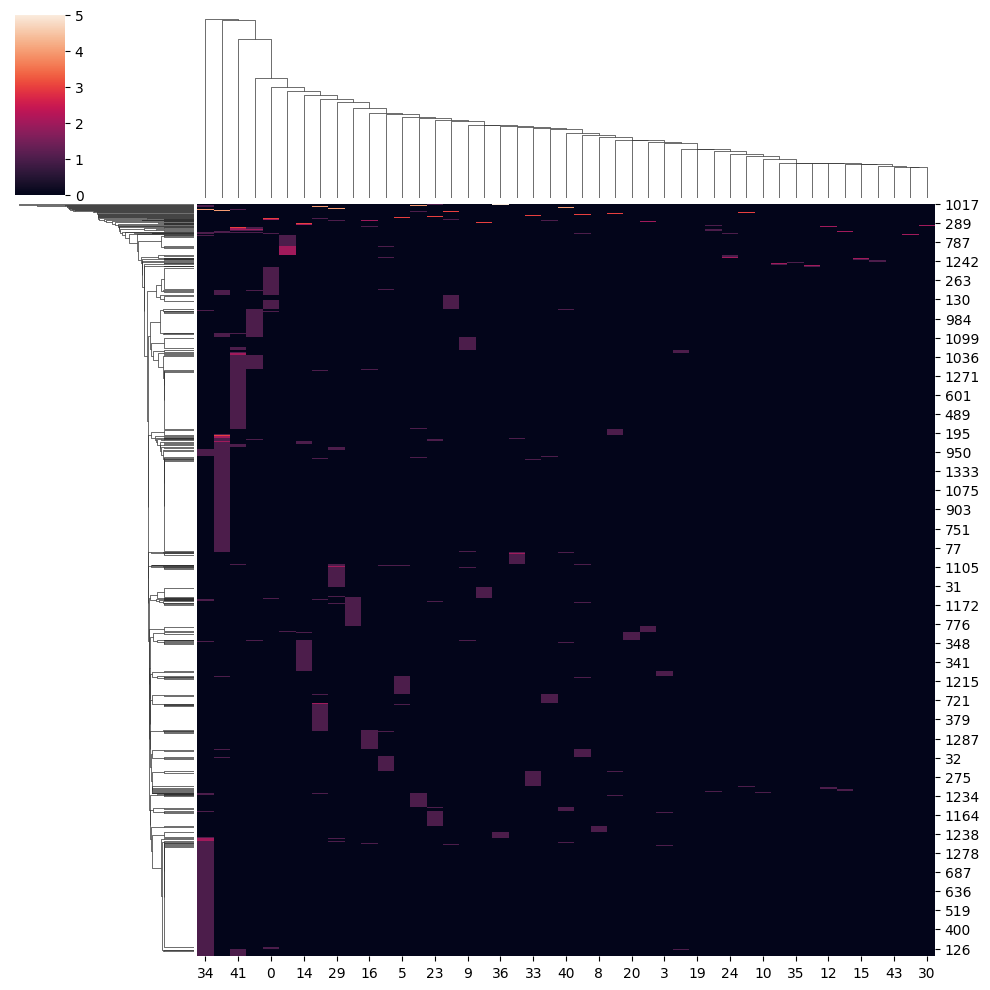

In [28]:
sns.clustermap(ec_adata_hvg50.X.A)

Checking what types latent core estimates --> No binaries! Lots of ternary but from biology we should know that they are in fact truncated (havy zero inflated)

In [29]:
tps = get_tps(ec_adata_hvg50.layers['counts'].A)

ordinal levels between 4 and 10 will be approximated by either countinuous or truncated type.
ordinal levels between 4 and 10 will be approximated by either countinuous or truncated type.
ordinal levels between 4 and 10 will be approximated by either countinuous or truncated type.
ordinal levels between 4 and 10 will be approximated by either countinuous or truncated type.
ordinal levels between 4 and 10 will be approximated by either countinuous or truncated type.
ordinal levels between 4 and 10 will be approximated by either countinuous or truncated type.
ordinal levels between 4 and 10 will be approximated by either countinuous or truncated type.
ordinal levels between 4 and 10 will be approximated by either countinuous or truncated type.
ordinal levels between 4 and 10 will be approximated by either countinuous or truncated type.
ordinal levels between 4 and 10 will be approximated by either countinuous or truncated type.
ordinal levels between 4 and 10 will be approximated by eith

In [30]:
np.unique(tps, return_counts=True)

(array(['ter', 'tru'], dtype='<U3'), array([31, 14], dtype=int64))

Estimating with all considered truncated

In [31]:
tps_hvg = ['tru' for i in range(ec_adata_hvg50.shape[1])]

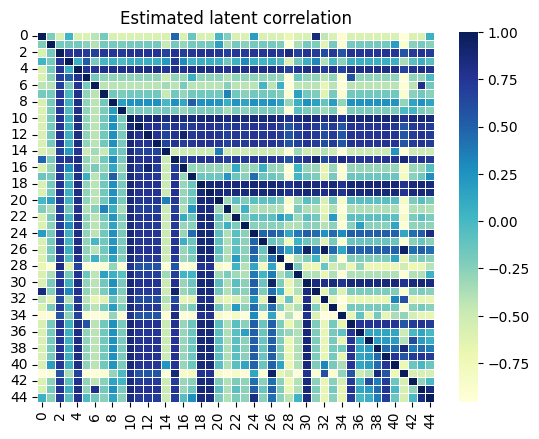

In [32]:
est = latentcor(ec_adata_hvg50.layers['counts'].A, tps=tps_hvg, method='approx', use_nearPD=False, nu=0.001, showplot=True)

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\statsmodels\stats\correlation_tools.py:90: IterationLimitWarning: 
Maximum iteration reached.

  warnings.warn(iteration_limit_doc, IterationLimitWarning)


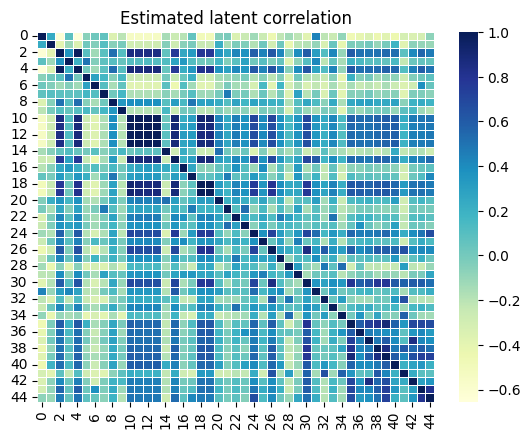

In [34]:
est_pd = latentcor(ec_adata_hvg50.layers['counts'].A, tps=tps_hvg, method='approx', use_nearPD=True, nu=0.001, showplot=True)

In [ ]:
evals, evecs = np.linalg.eig(est_pd['R'])

In [36]:
evals, evecs = np.linalg.eig(est_pd['R'])
assert np.all(evals>=0)

Trying to bring R back to pos def

In [46]:
from numpy import linalg as la

def nearestPD(A):
    """Find the nearest positive-definite matrix to input

    A Python/Numpy port of John D'Errico's `nearestSPD` MATLAB code [1], which
    credits [2].

    [1] https://www.mathworks.com/matlabcentral/fileexchange/42885-nearestspd

    [2] N.J. Higham, "Computing a nearest symmetric positive semidefinite
    matrix" (1988): https://doi.org/10.1016/0024-3795(88)90223-6
    """

    B = (A + A.T) / 2
    _, s, V = la.svd(B)

    H = np.dot(V.T, np.dot(np.diag(s), V))

    A2 = (B + H) / 2

    A3 = (A2 + A2.T) / 2

    if isPD(A3):
        return A3

    spacing = np.spacing(la.norm(A))
    # The above is different from [1]. It appears that MATLAB's `chol` Cholesky
    # decomposition will accept matrixes with exactly 0-eigenvalue, whereas
    # Numpy's will not. So where [1] uses `eps(mineig)` (where `eps` is Matlab
    # for `np.spacing`), we use the above definition. CAVEAT: our `spacing`
    # will be much larger than [1]'s `eps(mineig)`, since `mineig` is usually on
    # the order of 1e-16, and `eps(1e-16)` is on the order of 1e-34, whereas
    # `spacing` will, for Gaussian random matrixes of small dimension, be on
    # othe order of 1e-16. In practice, both ways converge, as the unit test
    # below suggests.
    I = np.eye(A.shape[0])
    k = 1
    while not isPD(A3):
        mineig = np.min(np.real(la.eigvals(A3)))
        A3 += I * (-mineig * k**2 + spacing)
        k += 1

    return A3


def isPD(B):
    """Returns true when input is positive-definite, via Cholesky"""
    try:
        _ = la.cholesky(B)
        return True
    except la.LinAlgError:
        return False

In [51]:
R = nearestPD(est['R'].to_numpy())

In [53]:
est['R'] = pd.DataFrame(R)

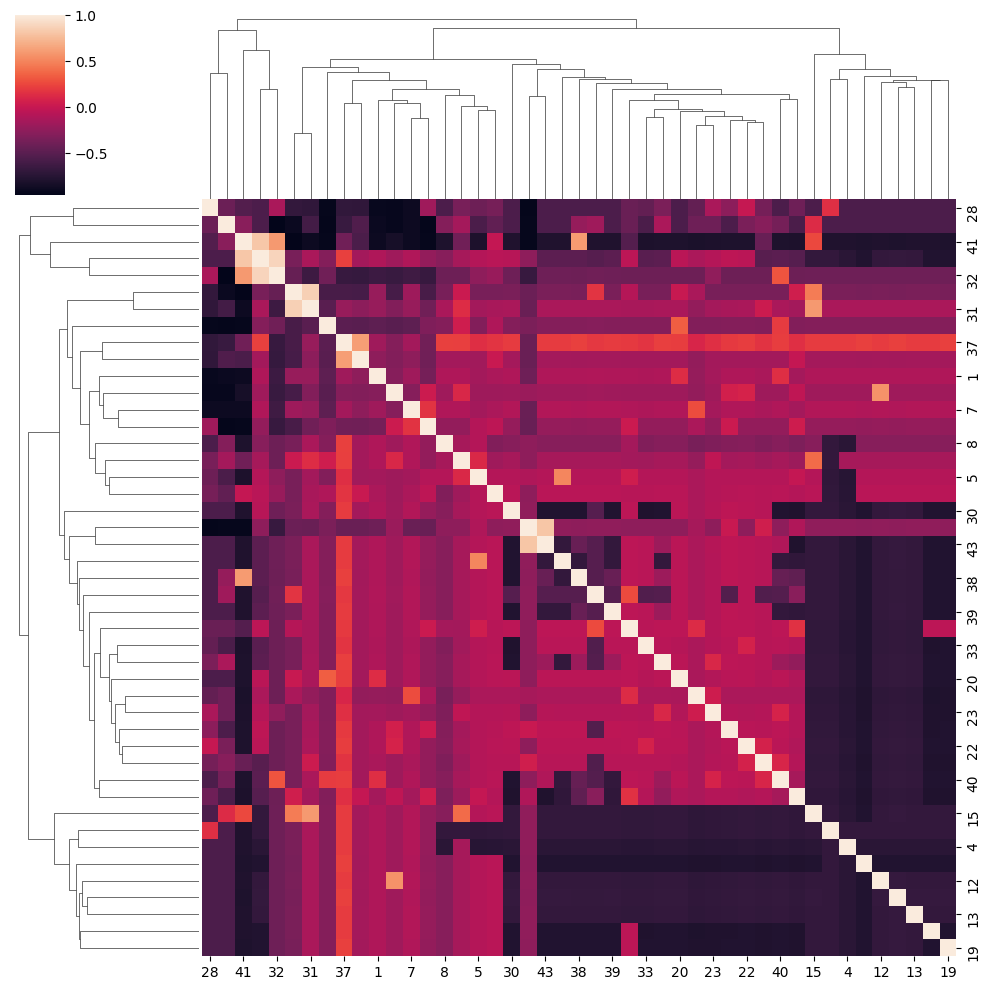

In [71]:
sns.clustermap(est['R'])

In [76]:
ggl_est = gg_lasso_network_analysis(N=ec_adata_hvg50.shape[0], estimate=est)
ggl_est.create_problem(S_col='R')
ggl_est.model_selection(lambda1_range=np.logspace(0, -5, 500))

 
SINGLE GRAPHICAL LASSO PROBLEM 
Regularization parameters:
{'lambda1': 0.05, 'mu1': None}
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 24 iterations with status: optimal.
ADMM terminated after 24 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 24 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 24 iterations with status: optimal.
ADMM terminated after 27 iterations with status: optimal.
ADMM terminated after 33 iterations with status: optimal.
ADMM terminated after 42 iterations with status: optimal.
ADMM terminated after 109 iterations with status: optimal.
ADMM terminated after 329 iterations 

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\gglasso\solver\single_admm_solver.py:215: UserWarning: Omega variable is not symmetric, largest deviation is 1.52587890625e-05.
  warnings.warn(f"Omega variable is not symmetric, largest deviation is {abs((Omega_t).T - Omega_t).max()}.")
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\gglasso\solver\single_admm_solver.py:218: UserWarning: Theta variable is not symmetric, largest deviation is 1.52587890625e-05.
  warnings.warn(f"Theta variable is not symmetric, largest deviation is {abs((Theta_t).T - Theta_t).max()}.")


ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.


c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\gglasso\solver\single_admm_solver.py:215: UserWarning: Omega variable is not symmetric, largest deviation is 3.0517578125e-05.
  warnings.warn(f"Omega variable is not symmetric, largest deviation is {abs((Omega_t).T - Omega_t).max()}.")
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\gglasso\solver\single_admm_solver.py:218: UserWarning: Theta variable is not symmetric, largest deviation is 3.0517578125e-05.
  warnings.warn(f"Theta variable is not symmetric, largest deviation is {abs((Theta_t).T - Theta_t).max()}.")


ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.


c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\gglasso\solver\single_admm_solver.py:215: UserWarning: Omega variable is not symmetric, largest deviation is 6.103515625e-05.
  warnings.warn(f"Omega variable is not symmetric, largest deviation is {abs((Omega_t).T - Omega_t).max()}.")
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\gglasso\solver\single_admm_solver.py:218: UserWarning: Theta variable is not symmetric, largest deviation is 6.103515625e-05.
  warnings.warn(f"Theta variable is not symmetric, largest deviation is {abs((Theta_t).T - Theta_t).max()}.")


ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal opti

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\gglasso\solver\single_admm_solver.py:215: UserWarning: Omega variable is not symmetric, largest deviation is 64.0.
  warnings.warn(f"Omega variable is not symmetric, largest deviation is {abs((Omega_t).T - Omega_t).max()}.")
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\gglasso\solver\single_admm_solver.py:218: UserWarning: Theta variable is not symmetric, largest deviation is 64.0.
  warnings.warn(f"Theta variable is not symmetric, largest deviation is {abs((Theta_t).T - Theta_t).max()}.")


ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.


c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\gglasso\solver\single_admm_solver.py:215: UserWarning: Omega variable is not symmetric, largest deviation is 128.0.
  warnings.warn(f"Omega variable is not symmetric, largest deviation is {abs((Omega_t).T - Omega_t).max()}.")
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\gglasso\solver\single_admm_solver.py:218: UserWarning: Theta variable is not symmetric, largest deviation is 128.0.
  warnings.warn(f"Theta variable is not symmetric, largest deviation is {abs((Theta_t).T - Theta_t).max()}.")


ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal optimal.
ADMM terminated after 1000 iterations with status: primal opti

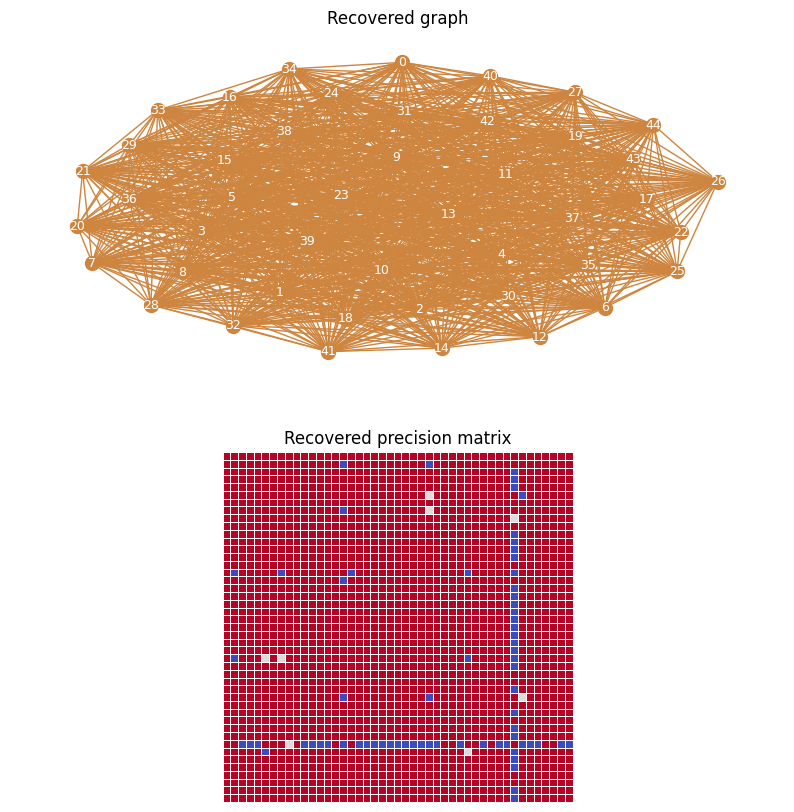

In [77]:
ggl_est.plot_graph_and_percision_matrix(fig_size=(10,10))

In [3]:
filter = sc.pp.filter_genes(ec_adata, min_cells=5, inplace=False)[0]
filter

array([False, False, False, ..., False, False, False])

In [4]:
ec_adata_filtered = ec_adata[:,filter]
ec_adata_filtered

View of AnnData object with n_obs × n_vars = 5964 × 1146
    obs: 'strains', 'n_genes_by_counts', 'total_counts', 'n_genes', 'n_counts'
    var: 'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'var_counts', 'n_cells'
    uns: 'genes_match', 'protein_match', 'unmatch_genes'
    layers: 'counts', 'norm_counts', 'sqrt_counts', 'sqrt_norm_counts'

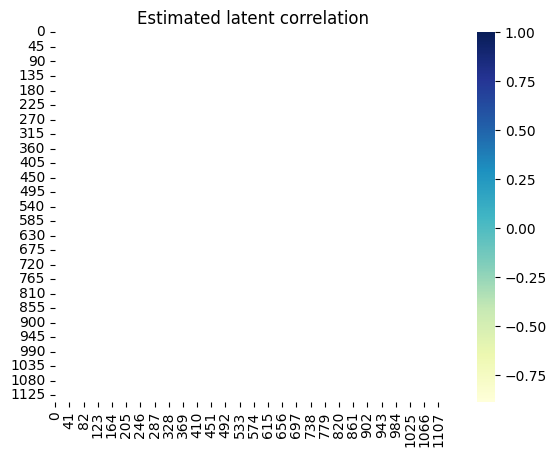

In [5]:
tps = ['tru' for i in range(ec_adata_filtered.shape[1])]
est_filtered = latentcor(ec_adata_filtered.layers['counts'].A, tps=tps, method='approx', use_nearPD=False, nu=0.001, showplot=True)

In [6]:
est_filtered['R']

,0,1,2,3,4,5,6,7,8,9,...,1136,1137,1138,1139,1140,1141,1142,1143,1144,1145
0,1.000000,0.881726,0.874820,0.881725,0.881557,0.880715,0.881725,0.881220,0.881052,0.881725,...,0.877178,0.862020,0.881557,0.879873,0.881725,0.881052,0.877346,0.878020,0.881388,0.878020
1,0.881726,1.000000,0.918014,0.922328,0.922223,0.921697,0.922539,0.922013,0.921908,0.922539,...,0.919487,0.962316,0.922223,0.921171,0.922434,0.921908,0.919592,0.920013,0.922118,0.920013
2,0.874820,0.918014,1.000000,0.284524,0.284520,0.284498,0.284532,0.284511,0.284507,0.284532,...,0.284409,0.331583,0.284520,0.284477,0.284528,0.284507,0.284414,0.284431,0.284515,0.284431
3,0.881725,0.922328,0.284524,1.000000,0.881557,0.880715,0.881725,0.881220,0.881052,0.881725,...,0.877178,0.862020,0.881557,0.879873,0.881725,0.881052,0.877346,0.878020,0.881388,0.934105
4,0.881557,0.922223,0.284520,0.881557,1.000000,0.867054,0.868002,0.867622,0.867433,0.868002,...,0.863075,0.846020,0.868001,0.866106,0.868002,0.867433,0.863264,0.864022,0.867812,0.864022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1141,0.881052,0.921908,0.284507,0.881052,0.867433,0.798749,0.908289,0.840195,0.826576,0.908289,...,0.496395,-0.194874,0.867433,0.728445,0.894670,1.000000,0.821017,0.822028,0.826577,0.886442
1142,0.877346,0.919592,0.284414,0.877346,0.863264,0.792851,0.905511,0.835099,0.821017,0.905511,...,0.496348,0.268023,0.863264,0.722435,0.891429,0.821017,1.000000,0.511177,0.511218,0.592469
1143,0.878020,0.920013,0.284431,0.878020,0.864022,0.794031,0.906016,0.836026,0.822028,0.906016,...,0.496356,-0.195171,0.864022,0.724037,0.892018,0.822028,0.511177,1.000000,0.570072,0.640446
1144,0.881388,0.922118,0.284515,0.881388,0.867812,0.798750,0.908541,0.840427,0.826577,0.908541,...,0.496400,-0.194841,0.867812,0.728446,0.894965,0.826577,0.511218,0.570072,1.000000,0.850024


<Axes: >

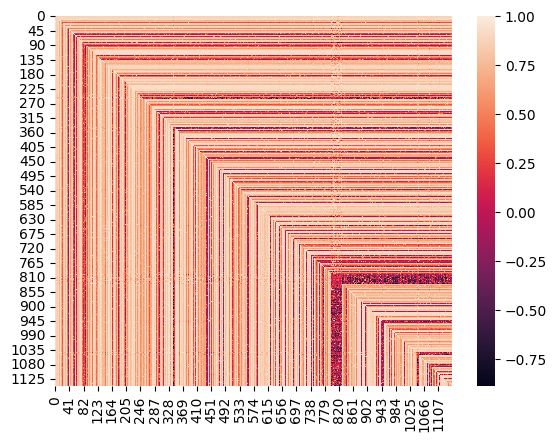

In [7]:
sns.heatmap(est_filtered['R'])

In [38]:
ec_adata_filtered

View of AnnData object with n_obs × n_vars = 5964 × 1146
    obs: 'strains', 'n_genes_by_counts', 'total_counts', 'n_genes', 'n_counts'
    var: 'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'var_counts', 'n_cells'
    uns: 'genes_match', 'protein_match', 'unmatch_genes'
    layers: 'counts', 'norm_counts', 'sqrt_counts', 'sqrt_norm_counts'

In [9]:
(ec_adata_filtered[0].X.A != 0)[0]

array([False, False, False, ..., False, False, False])

In [10]:
ec_adata_neg_filtered = ec_adata[:,np.invert(filter)]
ec_adata_neg_filtered

View of AnnData object with n_obs × n_vars = 5964 × 2233
    obs: 'strains', 'n_genes_by_counts', 'total_counts', 'n_genes', 'n_counts'
    var: 'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'var_counts', 'n_cells'
    uns: 'genes_match', 'protein_match', 'unmatch_genes'
    layers: 'counts', 'norm_counts', 'sqrt_counts', 'sqrt_norm_counts'

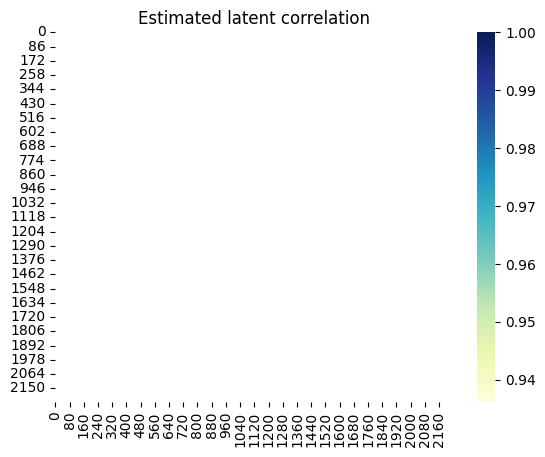

In [12]:
tps = ['tru']*ec_adata_neg_filtered.shape[1]
est_neg_filtered = latentcor(ec_adata_neg_filtered.layers['counts'].A, tps=tps, method='approx', use_nearPD=False, nu=0.001, showplot=True)

In [13]:
est_neg_filtered['R']

,0,1,2,3,4,5,6,7,8,9,...,2223,2224,2225,2226,2227,2228,2229,2230,2231,2232
0,1.000000,0.963184,0.963142,0.963184,0.963184,0.963184,0.963184,0.963142,0.963100,0.963184,...,0.96310,0.963184,0.963184,0.963184,0.963184,0.963184,0.963184,0.963184,0.963184,0.963184
1,0.963184,1.000000,0.976571,0.976613,0.976592,0.976613,0.976592,0.976571,0.976550,0.976613,...,0.97655,0.976592,0.976613,0.976592,0.976613,0.976613,0.976592,0.976592,0.976613,0.976613
2,0.963142,0.976571,1.000000,0.949713,0.949713,0.949713,0.949713,0.949713,0.949650,0.949713,...,0.94965,0.949713,0.949713,0.949713,0.949713,0.949713,0.949713,0.949713,0.949713,0.949713
3,0.963184,0.976613,0.949713,1.000000,0.976592,0.976613,0.976592,0.976571,0.976550,0.976613,...,0.97655,0.976592,0.976613,0.976592,0.976613,0.976613,0.976592,0.976592,0.976613,0.976613
4,0.963184,0.976592,0.949713,0.976592,1.000000,0.963184,0.963184,0.963142,0.986873,0.963184,...,0.96310,0.963184,0.963184,0.963184,0.963184,0.963184,0.963184,0.963184,0.963184,0.963184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2228,0.963184,0.976613,0.949713,0.976613,0.963184,0.976613,0.963184,0.949713,0.936200,0.976613,...,0.93620,0.963184,0.976613,0.963184,0.976613,1.000000,0.976592,0.976592,0.976613,0.976613
2229,0.963184,0.976592,0.949713,0.976592,0.963184,0.976592,0.963184,0.949713,0.936200,0.976592,...,0.93620,0.963184,0.976592,0.963184,0.976592,0.976592,1.000000,0.963184,0.963184,0.963184
2230,0.963184,0.976592,0.949713,0.976592,0.963184,0.976592,0.963184,0.949713,0.936200,0.976592,...,0.93620,0.963184,0.976592,0.963184,0.976592,0.976592,0.963184,1.000000,0.963184,0.963184
2231,0.963184,0.976613,0.949713,0.976613,0.963184,0.976613,0.963184,0.949713,0.936200,0.976613,...,0.93620,0.963184,0.976613,0.963184,0.976613,0.976613,0.963184,0.963184,1.000000,0.976613


<Axes: >

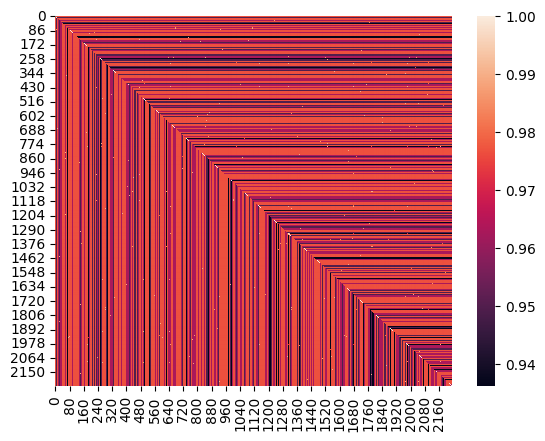

In [14]:
sns.heatmap(est_neg_filtered['R'])

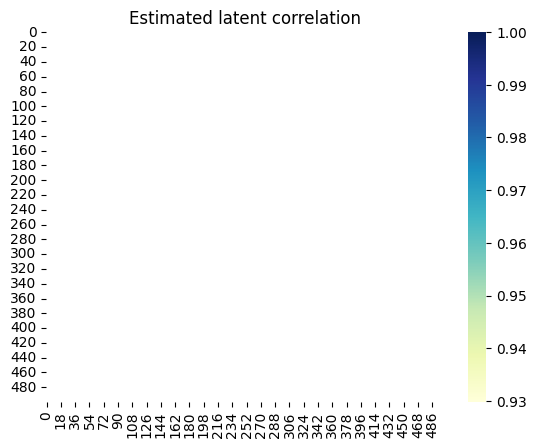

In [114]:
num_rows = 267*5
num_cols = 100*5

# Create an empty matrix filled with zeros
matrix = np.zeros((num_cols, num_rows))

# Loop through each column and randomly choose a row to place a 1
for i in range(num_cols):
    # Generate a random row index
    rand_row = np.random.randint(num_rows)
    # Place a 1 at the randomly chosen row index
    matrix[i, rand_row] = 1

# Transpose the matrix to get the desired shape
matrix = matrix.T


tps = ['tru']*100*5
est_neg_toy = latentcor(matrix, tps=tps, method='approx', use_nearPD=False, nu=0.001, showplot=True)

In [115]:
est_neg_toy['R']

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,0.929869,0.929869,0.929869,0.929869,0.929869,0.929869,0.929869,0.929869,0.929869,...,0.929869,0.929869,0.929869,0.929869,0.929869,0.929869,0.929869,0.929869,0.929869,0.929869
1,0.929869,1.000000,0.929869,0.929869,0.929869,0.929869,0.929869,0.929869,0.929869,0.929869,...,0.929869,0.929869,0.929869,0.929869,0.929869,0.929869,0.929869,0.929869,0.929869,0.929869
2,0.929869,0.929869,1.000000,0.929869,0.929869,0.929869,0.929869,0.929869,0.929869,0.929869,...,0.929869,0.929869,0.929869,0.929869,0.929869,0.929869,0.929869,0.929869,0.929869,0.929869
3,0.929869,0.929869,0.929869,1.000000,0.929869,0.929869,0.929869,0.929869,0.929869,0.929869,...,0.929869,0.929869,0.929869,0.929869,0.929869,0.929869,0.929869,0.929869,0.929869,0.929869
4,0.929869,0.929869,0.929869,0.929869,1.000000,0.929869,0.929869,0.929869,0.929869,0.929869,...,0.929869,0.929869,0.929869,0.929869,0.929869,0.929869,0.929869,0.929869,0.929869,0.929869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.929869,0.929869,0.929869,0.929869,0.929869,0.929869,0.929869,0.929869,0.929869,0.929869,...,0.929869,0.929869,0.929869,0.929869,0.929869,1.000000,0.929869,0.929869,0.929869,0.929869
496,0.929869,0.929869,0.929869,0.929869,0.929869,0.929869,0.929869,0.929869,0.929869,0.929869,...,0.929869,0.929869,0.929869,0.929869,0.929869,0.929869,1.000000,0.929869,0.929869,0.929869
497,0.929869,0.929869,0.929869,0.929869,0.929869,0.929869,0.929869,0.929869,0.929869,0.929869,...,0.929869,0.929869,0.929869,0.929869,0.929869,0.929869,0.929869,1.000000,0.929869,0.929869
498,0.929869,0.929869,0.929869,0.929869,0.929869,0.929869,0.929869,0.929869,0.929869,0.929869,...,0.929869,0.929869,0.929869,0.929869,0.929869,0.929869,0.929869,0.929869,1.000000,0.929869


In [15]:
R1 = est_filtered['R']
R1.shape

(1146, 1146)

In [16]:
R2 = est_neg_filtered['R']
R2.shape

(2233, 2233)

In [17]:
right = np.zeros((R1.shape[0], R2.shape[0]))

In [18]:
z1 = np.hstack((R1, right))
z1.shape

(1146, 3379)

In [19]:
bottom = np.zeros((R2.shape[0], R1.shape[0]))

In [20]:
z2 = np.hstack((bottom, R2))
z2.shape

(2233, 3379)

In [21]:
z = np.vstack((z1, z2))
z.shape

(3379, 3379)

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


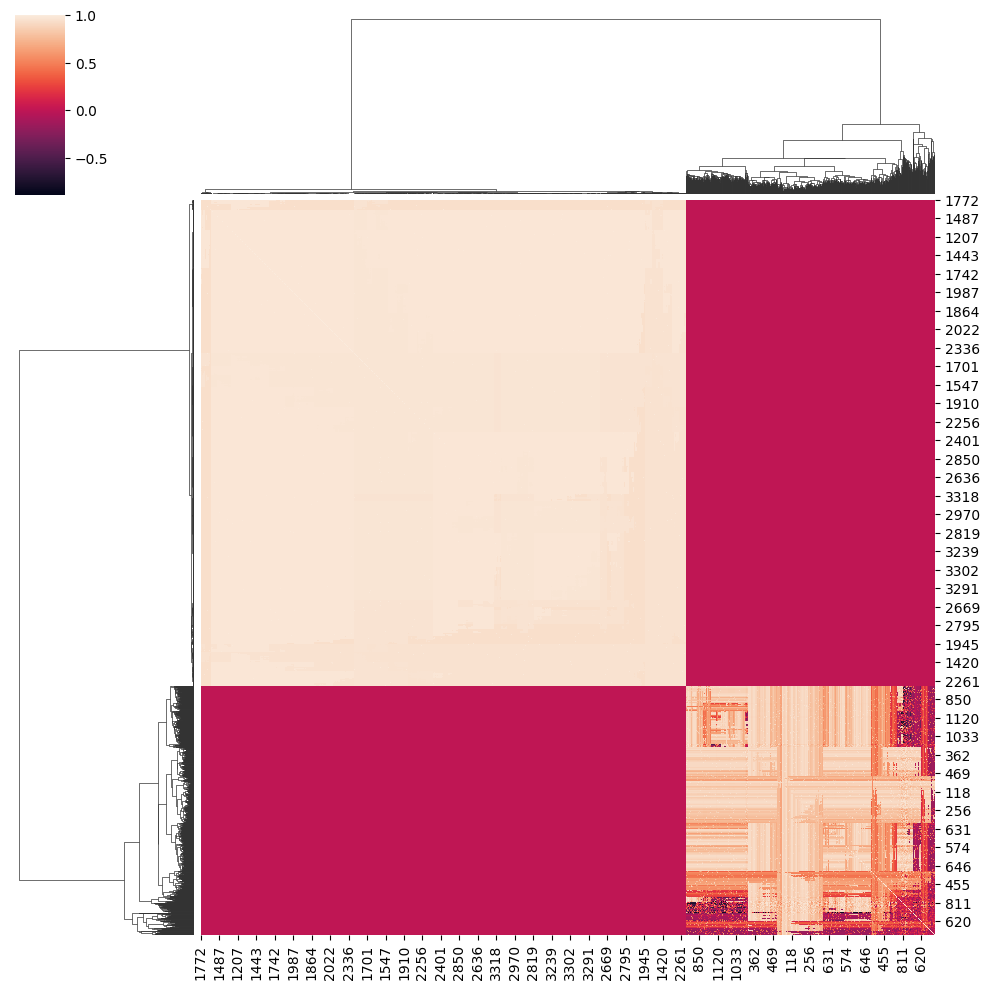

In [22]:
cm = sns.clustermap(z)
plt.show()

In [25]:
from scipy.cluster.hierarchy import linkage

In [28]:
pre_linkage = linkage(z, method='average', metric='euclidean')

In [29]:
ec_adata

AnnData object with n_obs × n_vars = 5964 × 3379
    obs: 'strains', 'n_genes_by_counts', 'total_counts', 'n_genes', 'n_counts'
    var: 'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'var_counts', 'n_cells'
    uns: 'genes_match', 'protein_match', 'unmatch_genes'
    layers: 'counts', 'norm_counts', 'sqrt_counts', 'sqrt_norm_counts'

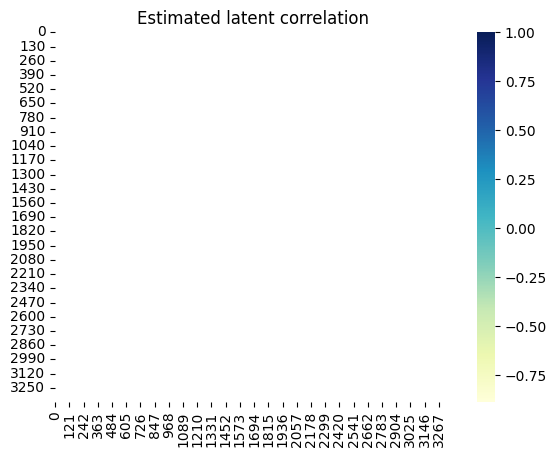

In [31]:
tps = ['tru']*ec_adata.shape[1]
est = latentcor(ec_adata.layers['counts'].A, tps=tps, method='approx', use_nearPD=False, nu=0.001, showplot=True)

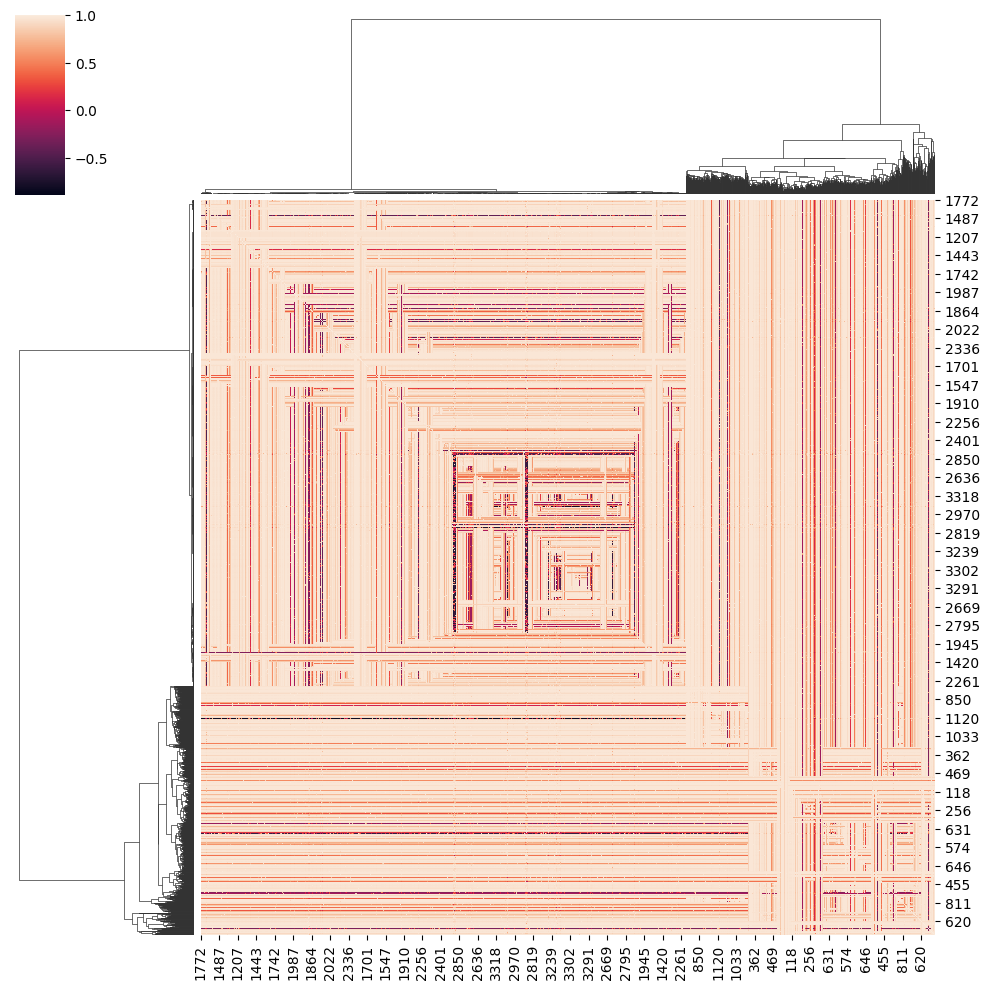

In [36]:
sns.clustermap(est['R'], row_linkage=pre_linkage, col_linkage=pre_linkage)

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

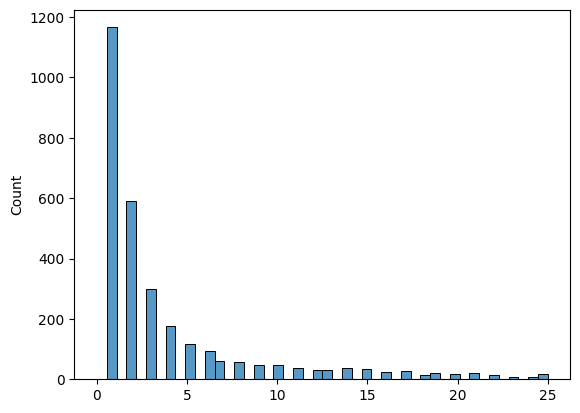

In [37]:
sns.histplot(sc.pp.filter_genes(ec_adata, min_cells=5, inplace=False)[1], binrange=(0, 25))

In [40]:
ec_adata_filtered

View of AnnData object with n_obs × n_vars = 5964 × 1146
    obs: 'strains', 'n_genes_by_counts', 'total_counts', 'n_genes', 'n_counts'
    var: 'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'var_counts', 'n_cells'
    uns: 'genes_match', 'protein_match', 'unmatch_genes'
    layers: 'counts', 'norm_counts', 'sqrt_counts', 'sqrt_norm_counts'

### Corrected HVG50

In [42]:
sc.pp.highly_variable_genes(ec_adata_filtered, n_top_genes=50)
ec_adata_filtered_hvg50 = ec_adata_filtered[:, ec_adata_filtered.var['highly_variable']].copy()
ec_adata_filtered_hvg50

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


AnnData object with n_obs × n_vars = 5964 × 50
    obs: 'strains', 'n_genes_by_counts', 'total_counts', 'n_genes', 'n_counts'
    var: 'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'var_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'genes_match', 'protein_match', 'unmatch_genes', 'hvg'
    layers: 'counts', 'norm_counts', 'sqrt_counts', 'sqrt_norm_counts'

In [44]:
sc.pp.calculate_qc_metrics(ec_adata_filtered_hvg50, inplace=True, percent_top=(5, 10, 25))

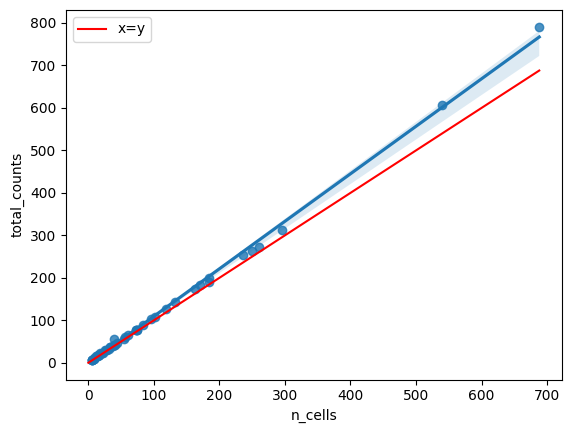

In [45]:
lim = min(ec_adata_filtered_hvg50.var.n_cells.max(), ec_adata.var.total_counts.max())
line = [0, lim]

sns.regplot(ec_adata_filtered_hvg50.var, x='n_cells', y='total_counts')
plt.plot(line, line, color='red', label='x=y')
plt.legend()
plt.show()

<Axes: >

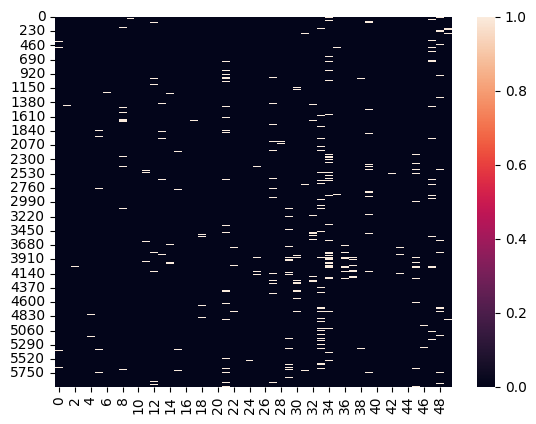

In [47]:
ec_adata_filtered_hvg50_bool_X = np.array(ec_adata_filtered_hvg50.X.A,dtype=bool)
sns.heatmap(ec_adata_filtered_hvg50_bool_X)

In [49]:
print(ec_adata_filtered_hvg50.shape)
sc.pp.filter_cells(ec_adata_filtered_hvg50, min_genes=1)
print(ec_adata_filtered_hvg50.shape)

(5964, 50)
(2979, 50)


c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\statsmodels\stats\correlation_tools.py:90: IterationLimitWarning: 
Maximum iteration reached.

  warnings.warn(iteration_limit_doc, IterationLimitWarning)


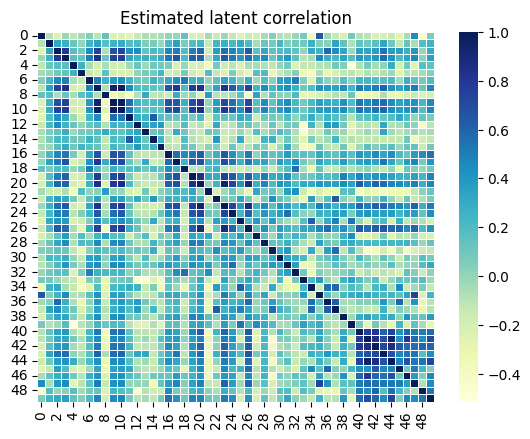

In [51]:
tps = ['tru']*ec_adata_filtered_hvg50.shape[1]
est_filtered_hvg50 = latentcor(ec_adata_filtered_hvg50.layers['counts'].A, tps=tps, method='approx', use_nearPD=True, nu=0.001, showplot=True)

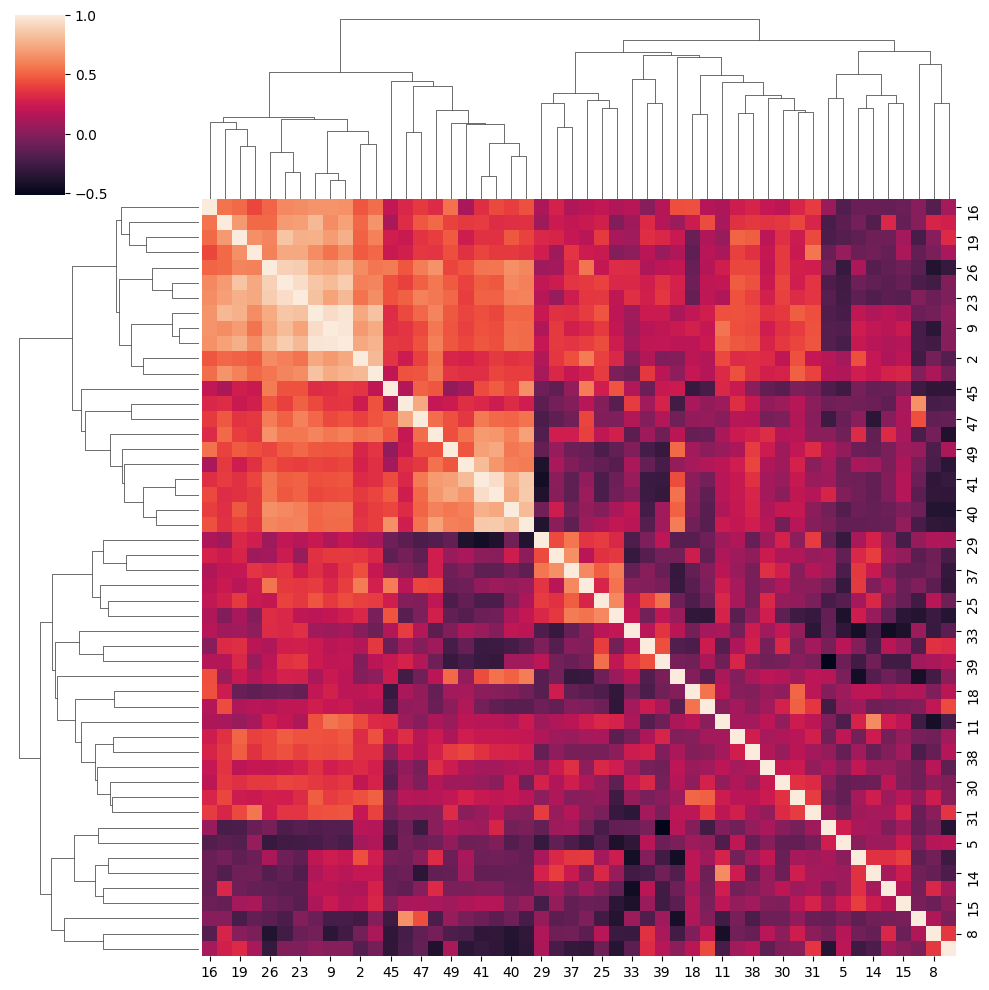

In [52]:
sns.clustermap(est_filtered_hvg50['R'])

In [55]:
ggl_est_filtered = gg_lasso_network_analysis(N=ec_adata_filtered_hvg50.shape[0], estimate=est_filtered_hvg50)
ggl_est_filtered.create_problem(S_col='R')
ggl_est_filtered.model_selection(lambda1_range=np.logspace(0, -5, 100))

 
SINGLE GRAPHICAL LASSO PROBLEM 
Regularization parameters:
{'lambda1': 0.05, 'mu1': None}
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 27 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 49 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 52 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 56 iterations with status: optimal.
ADMM terminated after 21 iterations wi

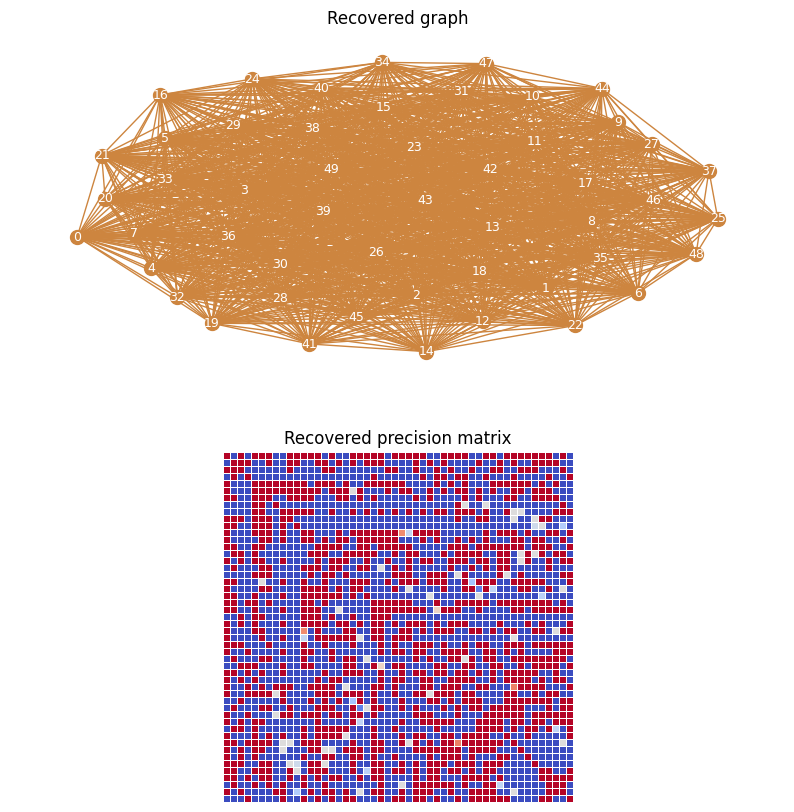

In [57]:
ggl_est_filtered.plot_graph_and_percision_matrix(fig_size=(10,10))